# CANnolo
## LSTM auto-encoder based intrusion detection system for CAN traffic

In [1]:
%load_ext tensorboard
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import math
from tqdm import tqdm

sys.path.append('../')

from dataset_loader import load_dataset, load_train
from read import __pre_processing


In [2]:
dataset = load_train(dataset_folder='../../datasets/')
dataset_validation = load_dataset(dataset_folder='../../datasets/', exp=4)
dataset_threshold = load_dataset(dataset_folder='../../datasets/', exp=5)
id = '41E'
dataset = dataset.loc[dataset['Id'] == id]
dataset_validation = dataset_validation.loc[dataset_validation['Id'] == id]
dataset_threshold = dataset_threshold.loc[dataset_threshold['Id'] == id]

Extracting..
..done
C-1-AlfaRomeo-Giulia(exp 4) selected
Extracting..
..done
C-1-AlfaRomeo-Giulia(exp 5) selected
Extracting..
..done


In [3]:
"""big_intervals = {}
for i in range(1, len(dataset.index)):
    if float(dataset['Time'][dataset.index[i]]) - float(dataset['Time'][[dataset.index[i-1]]]) > 1:
        big_intervals[dataset.index[i-1]]=(float(dataset['Time'][dataset.index[i]]) - float(dataset['Time'][[dataset.index[i-1]]]))"""


"big_intervals = {}\nfor i in range(1, len(dataset.index)):\n    if float(dataset['Time'][dataset.index[i]]) - float(dataset['Time'][[dataset.index[i-1]]]) > 1:\n        big_intervals[dataset.index[i-1]]=(float(dataset['Time'][dataset.index[i]]) - float(dataset['Time'][[dataset.index[i-1]]]))"

In [4]:
"""big_intervals_validation = {}
for i in range(1, len(dataset_validation.index)):
    if float(dataset_validation['Time'][dataset_validation.index[i]]) - float(dataset_validation['Time'][[dataset_validation.index[i-1]]]) > 1:
        big_intervals_validation[dataset_validation.index[i-1]]=(float(dataset_validation['Time'][dataset_validation.index[i]]) - float(dataset_validation['Time'][[dataset_validation.index[i-1]]]))"""

"big_intervals_validation = {}\nfor i in range(1, len(dataset_validation.index)):\n    if float(dataset_validation['Time'][dataset_validation.index[i]]) - float(dataset_validation['Time'][[dataset_validation.index[i-1]]]) > 1:\n        big_intervals_validation[dataset_validation.index[i-1]]=(float(dataset_validation['Time'][dataset_validation.index[i]]) - float(dataset_validation['Time'][[dataset_validation.index[i-1]]]))"

In [5]:
print(tf.__version__)
if tf.test.gpu_device_name(): 
    print('Default GPU: ' + tf.test.gpu_device_name())
else:
    print("Non trovo la gpu")

2.1.0
Default GPU: /device:GPU:0


In [6]:
dlc = int(dataset['Dlc'].tolist()[0])

# Don't use bits that don't flip as input (Compact notation)
payloads = dataset['Payload'].tolist()
bitflips = __pre_processing(payloads, dlc)[0]
valid_bits = [i for i in range(len(bitflips)) if bitflips[i] != 0]
#valid_bits = range(2,14)
reduced_payloads = ["".join(np.array(list(x))[valid_bits]) for x in payloads]
dataset['Payload'] = reduced_payloads

payloads_validation = dataset_validation['Payload'].tolist()
reduced_payloads = ["".join(np.array(list(x))[valid_bits]) for x in payloads_validation]
dataset_validation['Payload'] = reduced_payloads

payloads_threshold = dataset_threshold['Payload'].tolist()
reduced_payloads = ["".join(np.array(list(x))[valid_bits]) for x in payloads_threshold]
dataset_threshold['Payload'] = reduced_payloads

In [7]:
# Number of input packets
n = 40
k = len(valid_bits)
batch_size = 128


In [8]:
payloads = dataset['Payload'].tolist()
payloads_validation = dataset_validation['Payload'].tolist()
payloads = np.array([np.array(list(map(int, list(payload)))) for payload in payloads])
payloads_validation = np.array([np.array(list(map(int, list(payload)))) for payload in payloads_validation])
payloads_threshold = dataset_threshold['Payload'].tolist()
payloads_threshold = np.array([np.array(list(map(int, list(payload)))) for payload in payloads_threshold])

In [9]:
def build_x_y(payloads):
    y = np.array([payloads[i:i+n] for i in range(len(payloads) - n + 1)])
    x = np.flip(y, axis=1)
    decoder_x = np.zeros(shape = (x.shape[0], 1, k), dtype=np.float32)
    return [x, decoder_x], y

x_train, y_train = build_x_y(payloads)
x_threshold, y_threshold = build_x_y(payloads_threshold)
x_validation, y_validation = build_x_y(payloads_validation)

In [10]:
additional_xs = []
additional_ys = []
add = [1,2,6,8]
for i in add:
    additional_dataset = load_dataset(dataset_folder='../../datasets/', exp=i)
    additional_dataset = additional_dataset.loc[additional_dataset['Id'] == id]

    additional_payloads = additional_dataset['Payload'].tolist()
    reduced_payloads = ["".join(np.array(list(x))[valid_bits]) for x in additional_payloads]
    additional_dataset['Payload'] = reduced_payloads

    additional_payloads = additional_dataset['Payload'].tolist()
    additional_payloads = np.array([np.array(list(map(int, list(payload)))) for payload in additional_payloads])
    additional_x, additional_y = build_x_y(additional_payloads)
    additional_xs.append(additional_x)
    additional_ys.append(additional_y)

C-1-AlfaRomeo-Giulia(exp 1) selected
Extracting..
..done
C-1-AlfaRomeo-Giulia(exp 2) selected
Extracting..
..done
C-1-AlfaRomeo-Giulia(exp 6) selected
Extracting..
..done
C-1-AlfaRomeo-Giulia(exp 8) selected
Extracting..
..done


In [11]:

# Encoder
input_shape = (n, k)
encoder_inputs = tf.keras.layers.Input(shape = input_shape, name = 'encoder_inputs')
encoder = tf.keras.layers.Dense(256, activation='tanh', name='encoder_dense')(encoder_inputs)
encoder = tf.keras.layers.Dropout(0.2, name='drop')(encoder)
encoder = tf.keras.layers.LSTM(128, return_sequences=True, name='encoder_lstm_0')(encoder)
encoder_output, state_h, state_c = tf.keras.layers.LSTM(128, return_sequences=True, return_state=True, name='encoder_lstm_1')(encoder)

encoder_states = [state_h, state_c]

decoder_lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True, return_state=True, name="decoder_lstm1")
decoder_lstm_2 = tf.keras.layers.LSTM(128, return_sequences=True, return_state=False, name="decoder_lstm2")
decoder_dense = tf.keras.layers.Dense(k, activation="sigmoid", name="dense_output")
reshape = tf.keras.layers.Reshape((1, 128), name = 'reshape')
concatenate = tf.keras.layers.Concatenate(name = 'concatenate')


all_outputs = []
decoder_inputs = tf.keras.layers.Input(shape=(1, k))
inputs = concatenate([reshape(encoder_output[:,n-1,:]), decoder_inputs])

for i in tqdm(range(n)):
    outputs_lstm1, state_h, state_c = decoder_lstm_1(inputs, initial_state=encoder_states)
    outputs_lstm2 = decoder_lstm_2(outputs_lstm1)
    outputs = decoder_dense(outputs_lstm2)
    all_outputs.append(outputs)
    if i != n-1:
        inputs = concatenate([reshape(encoder_output[:,n-2-i,:]), outputs])
    encoder_states = [state_h, state_c]

# Concatenate all predictions
decoder_outputs = tf.keras.layers.Lambda(lambda x: tf.keras.backend.concatenate(x, axis=1))(all_outputs)

model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
#model.summary()


100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 40/40 [00:19<00:00,  2.00it/s]


In [12]:
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer = optimizer, loss = loss, metrics=['binary_accuracy'])

In [13]:
additional_xs.append(x_train)
additional_ys.append(y_train)
additional_xs, additional_ys = [np.concatenate([add_set[0] for add_set in additional_xs]), np.concatenate([add_set[1] for add_set in additional_xs])], np.concatenate(additional_ys)

In [14]:
class InputSequence(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, is_validation = False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.indices = np.arange(self.x[0].shape[0])
        self.count = 0
        np.random.shuffle(self.indices)

    def __len__(self):
        return math.ceil(len(self.x[0]) / self.batch_size)

    def __getitem__(self, idx):
        inds = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x_encoder = self.x[0][inds]
        batch_x_decoder = self.x[1][inds]
        batch_y = self.y[inds]

        self.count += 1

        if self.count == len(self):
            self.count = 0
            np.random.shuffle(self.indices)

        return [batch_x_encoder, batch_x_decoder], batch_y

        
#train_sequence = InputSequence(x_train, y_train, batch_size)
train_sequence = InputSequence(additional_xs, additional_ys, batch_size)
validation_sequence = InputSequence(x_validation, y_validation, batch_size)



In [15]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'CANnolo_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CANNolo'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

callbacks = []

# Model checkpoint
# ----------------
use_ckpt = False
if use_ckpt:
    ckpt_dir = os.path.join(exp_dir, 'ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                    save_weights_only=True)  # False to save the model directly
    callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)

    
%tensorboard --logdir {exps_dir}
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    callbacks.append(es_callback)



#model.fit(x_train, y_train, validation_data=(x_validation, y_validation), batch_size = batch_size, epochs=10, callbacks = callbacks)

model.fit(x=train_sequence, epochs=5, validation_data=validation_sequence)#, callbacks = callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Launching TensorBoard...

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 521 steps, validate for 96 steps
Epoch 1/5
521/521 [==============================] - 193s 370ms/step - loss: 0.3597 - binary_accuracy: 0.7931 - val_loss: 0.2610 - val_binary_accuracy: 0.8884
Epoch 2/5
521/521 [==============================] - 74s 142ms/step - loss: 0.0651 - binary_accuracy: 0.9841 - val_loss: 0.0429 - val_binary_accuracy: 0.9930
Epoch 3/5
521/521 [==============================] - 74s 142ms/step - loss: 0.0116 - binary_accuracy: 0.9993 - val_loss: 0.0216 - val_binary_accuracy: 0.9970
Epoch 4/5
521/521 [==============================] - 74s 142ms/step - loss: 0.0054 - binary_accuracy: 0.9998 - val_loss: 0.0140 - val_binary_accuracy: 0.9979
Epoch 5/5
521/521 [==============================] - 74s 142ms/step - loss: 0.0031 - binary_accuracy: 0.9999 - val_loss: 0.0109 - val_binary_accuracy: 0.9979


In [ ]:
models_dir = os.path.join(cwd, 'Models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_dir = os.path.join(models_dir, model_name + '_' + str(now))
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_json = model.to_json()
model_path = os.path.join(model_dir, 'model.json')
with open(model_path, "w") as json_file:
    json_file.write(model_json)

weights_path = os.path.join(model_dir, 'weights.h5')
model.save_weights(weights_path)



In [ ]:
import tensorflow as tf
import os

try:
    model
except:
    cwd = os.getcwd()
    models_dir = os.path.join(cwd, 'Models')
    model_dir = os.path.join(models_dir, 'CANNolo_Nov17_14-54-47')

    model_path = os.path.join(model_dir, 'model.json')
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)

    weights_path = os.path.join(model_dir, 'weights.h5')
    model.load_weights(weights_path)

In [16]:
reconstructions = model.predict(x_threshold, verbose=1)

5554/5554 [==============================] - 36s 7ms/sample


In [17]:
epsilon_param = 1e-15

reconstruction_errors = -1 * (y_threshold * np.log(reconstructions + epsilon_param)
                                + (1 - y_threshold) * np.log(1 - reconstructions + epsilon_param))
flattened_errors = np.reshape(reconstruction_errors,
                                (reconstruction_errors.shape[0] * reconstruction_errors.shape[1],
                                reconstruction_errors.shape[2]))

In [18]:
def gaussian(data):
    """
    Finds the mean and covariance of a multivariate sequence
    """ 
    mu = data.mean(axis=0)
    v = (data-mu).T @ (data-mu) / data.shape[0]
    return mu, v

mu, sigma = gaussian(flattened_errors)

def anomaly_score(e, mu, sigma):
    """
    Finds the Mahalanobis distance between an observation error e,
    w.r.t. the mean and covariance.
    """
    distance = np.dot((e - mu).T, np.linalg.inv(sigma))
    distance = np.dot(distance, (e-mu))
    return distance

scores = [anomaly_score(flattened_errors[f], mu, sigma) for f in tqdm(range(len(flattened_errors)))]

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 222160/222160 [00:11<00:00, 19461.30it/s]


In [19]:
print(np.mean(scores))
print(np.std(scores))
print(np.max(scores))

33.99999999999999
172.53498488161344
10982.515133669984


In [20]:
# JUST A CHECK

path = '../../datasets/REPLAYED__CANNOLO_STYLE__MASQUERADE__V2.csv'
test = pd.read_csv(path)

test = test.loc[test['Id'] == id]

y_test_true = test['IsTampered'].tolist()

dlc = int(dataset['Dlc'].tolist()[0])
# Don't use bits that don't flip as input (Compact notation)
payloads = test['Payload'].tolist()
reduced_payloads = ["".join(np.array(list(x))[valid_bits]) for x in payloads]
test['Payload'] = reduced_payloads

payloads = test['Payload'].tolist()
n_packets = len(payloads)
payloads = np.array([np.array(list(map(int, list(payload)))) for payload in payloads])

x_tamp, y_tamp = build_x_y(payloads)

r = model.predict(x_tamp, verbose = 1)


12212/12212 [==============================] - 23s 2ms/sample


In [21]:
reconstruction_errors_tamp = -1 * (y_tamp * np.log(r + epsilon_param)
                                + (1 - y_tamp) * np.log(1 - r + epsilon_param))
flattened_errors_tamp = np.reshape(reconstruction_errors_tamp,
                                (reconstruction_errors_tamp.shape[0] * reconstruction_errors_tamp.shape[1],
                                reconstruction_errors_tamp.shape[2]))

scores_tamp = [anomaly_score(flattened_errors_tamp[f], mu, sigma) for f in tqdm(range(len(flattened_errors_tamp)))]

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 488480/488480 [00:25<00:00, 19434.02it/s]


In [22]:
print(np.mean(scores_tamp))
print(np.std(scores_tamp))
print(np.max(scores_tamp))

281.22103535745475
3412.6362525407912
97330.78757976624


In [23]:
# returns a list containing for every original packet the scores from every window it appears in (max 40)
def calculate_scores_packets(scores, num_packets):
    scores = np.array(scores)
    scores = scores.reshape(num_packets - n + 1, n)
    scores_packets = [[] for _ in range(num_packets)]
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            scores_packets[i + j].append(scores[i][j])
    return scores_packets

# Reshapes the scores to group the scores of each window
def calculate_scores_windows(scores, num_packets):
    scores = np.array(scores)
    return scores.reshape(num_packets - n + 1, n)
    
#scores_threshold_packets = calculate_scores_packets(scores, len(payloads_threshold))

#average_scores_threshold_packets = [np.mean(s) for s in scores_threshold_packets]


In [24]:
scores_test_packets = calculate_scores_packets(scores_tamp, len(payloads))

In [25]:
average_scores_test_packets = [np.mean(s) for s in scores_test_packets]

In [26]:
from sklearn import metrics

threshold = np.percentile(scores, 99.99)
y_predicted = [(1 if average_scores_test_packets[i] > threshold else 0) for i in range(len(average_scores_test_packets))]

cm = metrics.confusion_matrix(y_test_true, y_predicted)

print('True negatives: ' + str(cm[0][0]))
print('False negatives: ' + str(cm[1][0]))
print('True positives: ' + str(cm[1][1]))
print('False positives: ' + str(cm[0][1]))

True negatives: 12100
False negatives: 51
True positives: 93
False positives: 7


In [27]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_true, average_scores_test_packets)
roc_auc = metrics.auc(fpr, tpr)

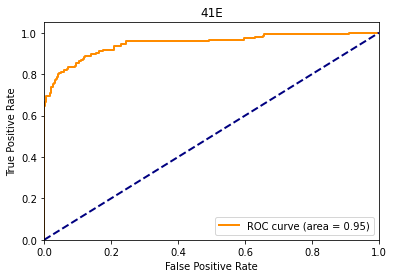

In [28]:
import matplotlib.pyplot as plt 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(id)
plt.legend(loc="lower right")
plt.show()

In [29]:
scores_test_windows = calculate_scores_windows(scores_tamp, len(payloads))
max_scores_test_windows = [np.max(s) for s in scores_test_windows]

In [30]:
# As the true labels are per packet, returns per window true labels where the 1 represents windows with at least one tampered packet
def generate_windows_true(packets_test_true, num_packets):
    y_test_true = []
    for i in range(num_packets-n+1):
        y_test_true.append(1 if any(packets_test_true[i:i+n-1]) else 0)
    return y_test_true



In [31]:
y_test_true_windows = generate_windows_true(y_test_true, len(payloads))
fpr, tpr, thresholds = metrics.roc_curve(y_test_true_windows, max_scores_test_windows)
roc_auc = metrics.auc(fpr, tpr)

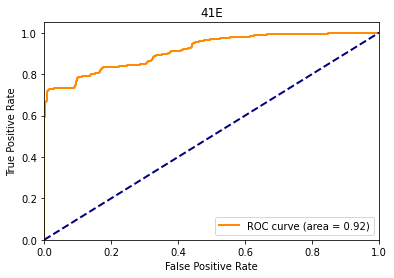

In [32]:
import matplotlib.pyplot as plt 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(id)
plt.legend(loc="lower right")
plt.show()

In [33]:
# Divides the dataset in split windows, differently from training set where windows move of one packets each time step here it moves n packets each time step
def build_x_y_split_windows(payloads):
    y = np.array([payloads[i*n:i*n+n] for i in range(math.floor(len(payloads)/n))])
    x = np.flip(y, axis=1)
    decoder_x = np.zeros(shape = (x.shape[0], 1, k), dtype=np.float32)
    return [x, decoder_x], y

def generate_split_windows_true(packets_test_true, num_packets):
    y_test_true = []
    for i in range(math.floor(num_packets/n)):
        y_test_true.append(1 if any(packets_test_true[i*n:i*n+n]) else 0)
    return y_test_true

def calculate_scores_split_windows(scores, num_packets):
    scores = np.array(scores)
    return scores.reshape(math.floor(num_packets/n), n)

In [34]:
x_tamp_wind, y_tamp_wind = build_x_y_split_windows(payloads)
r_wind = model.predict(x_tamp_wind, verbose = 1)

306/306 [==============================] - 1s 3ms/sample


In [35]:
reconstruction_errors_tamp_wind = -1 * (y_tamp_wind * np.log(r_wind + epsilon_param)
                                + (1 - y_tamp_wind) * np.log(1 - r_wind + epsilon_param))
flattened_errors_tamp_wind = np.reshape(reconstruction_errors_tamp_wind,
                                (reconstruction_errors_tamp_wind.shape[0] * reconstruction_errors_tamp_wind.shape[1],
                                reconstruction_errors_tamp.shape[2]))

scores_tamp_wind = [anomaly_score(flattened_errors_tamp_wind[f], mu, sigma) for f in tqdm(range(len(flattened_errors_tamp_wind)))]

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 12240/12240 [00:00<00:00, 20696.05it/s]


In [36]:
scores_split_windows = calculate_scores_split_windows(scores_tamp_wind, len(payloads))
max_scores_split_windows = [np.max(s) for s in scores_split_windows]

In [37]:
y_test_true_split_wind = generate_split_windows_true(y_test_true, len(payloads))

fpr, tpr, thresholds = metrics.roc_curve(y_test_true_split_wind, max_scores_split_windows)
roc_auc = metrics.auc(fpr, tpr)

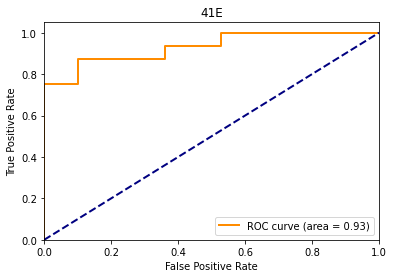

In [38]:
import matplotlib.pyplot as plt 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(id)
plt.legend(loc="lower right")
plt.show()

In [39]:
threshold = np.percentile(scores, 99.99)
y_predicted = [(1 if max_scores_split_windows[i] > threshold else 0) for i in range(len(max_scores_split_windows))]

cm = metrics.confusion_matrix(y_test_true_split_wind, y_predicted)

print('True negatives: ' + str(cm[0][0]))
print('False negatives: ' + str(cm[1][0]))
print('True positives: ' + str(cm[1][1]))
print('False positives: ' + str(cm[0][1]))

True negatives: 287
False negatives: 4
True positives: 12
False positives: 3
